In [68]:
import os
import pysam
import pickle as pkl
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
import statsmodels.api as sm

from sklearn.pipeline import Pipeline

import ipywidgets as widgets
from ipywidgets import interact

In [6]:
from genome_helpers import (
    # compute_af,
    inverse_rank_normalization,
    process_plant_phenotype,
    get_genome_metadata
)

Para obtener la frecuencia de los alelos alternativo, usamos el campo `DP4` del archivo VCF, con las siguientes componentes:

| Campo   | Descripción                                      |
|---------|------------------------------------------------|
| DP4[0]  | Reads forward para el alelo de referencia.    |
| DP4[1]  | Reads reverse para el alelo de referencia.    |
| DP4[2]  | Reads forward para el alelo alternativo.      |
| DP4[3]  | Reads reverse para el alelo alternativo.      |


In [7]:
def compute_af(record):
    dp4 = record.info['DP4']
    if sum(dp4) == 0:
        return None
    allele_freq = (dp4[2]+dp4[3]) / sum(dp4)
    return allele_freq


def get_dp4(record):
    
    dp4 = record.info['DP4']
    if sum(dp4) == 0:
        return None
    
    return dp4


def get_freqs_from_vcf(vcf_file):
    
    bgi_id = os.path.basename(vcf_file).replace(".vcf.gz", "")

    try:
        vcf_file = pysam.VariantFile(vcf_file)
    except Exception as e:
        print(e)
        return {bgi_id: None}
        
    variant_freq   = {(record.chrom, record.pos): compute_af(record) for record in vcf_file.fetch()}
    variant_counts = {(record.chrom, record.pos): get_dp4(record)    for record in vcf_file.fetch()}

    # variant_dict.update({sample_info: set(variant_positions)})
    # variant_freq_dict.update({bgi_id: variant_freq})

    return {bgi_id: variant_freq}, {bgi_id: variant_counts}


def get_sample_info(sample_id, metadata):

    sample_info = metadata.loc[metadata.BGI_ID == sample_id, ["generation", "rep", "treatment"]]    

    if len(sample_info) == 1:
        sample_info = sample_info.iloc[0].to_list()
        sample_info = tuple(sample_info)
    elif len(sample_info) == 0:
        print(ValueError(f"Sample with {sample_id} has no corresponding metadata.")) 
        return None
    else:
        raise(ValueError(f"Sample with {sample_id} has more than one associated sample."))

    return sample_info


def process_vcf_folder(vcf_folder, cache_file="vcf_dictionary.pkl"):

    """
    
    """
    
    files = [ file for file in os.listdir(vcf_folder) if file.endswith(".vcf.gz") or file.endswith(".vcf") ]

    variant_freq_dicts = {}
    variant_count_dicts = {}
    
    for file in tqdm(files):
           
        sample_id = file.replace(".vcf.gz", "")
        # sample_info = get_sample_info(sample_id, genome_metadata)        
        variant_freq_dict, variant_count_dict = get_freqs_from_vcf(f"{vcf_folder}/{file}")

        variant_freq_dicts.update(variant_freq_dict)
        variant_count_dicts.update(variant_count_dict)
                
    return variant_freq_dicts, variant_count_dicts

'asfgasdf^'

In [558]:
import re


def phred_quality(qual_string):
    return [ord(q) - 33 for q in qual_string]


def count_alleles(row):

    base_calls = row["bases"]    
    print(f"{len(base_calls)=}")

    quality_scores = phred_quality(row["qual"])
    print(f"{quality_scores=}")
    print(f"{len(quality_scores)=}")
    
    ref_base = row["ref"].upper()
    print(f"{ref_base=}")

    base_calls = re.sub(pattern="\^.", repl="", string=base_calls)
    
    # base_calls.replace('$', "").replace('^]', "").replace('^I', "")

    n_bases = len(base_calls.replace("-", "").replace("+", ""))

    # Reemplazar '.' y ',' con la base de referencia
    base_calls = base_calls.replace('.', ref_base).replace(',', ref_base)
    print(f"{base_calls=}")
    print(f"{len(base_calls)=}")
    
    filtered_bases = "".join([base_calls[i] for i in range(n_bases) if quality_scores[i] >= 20])
    print(filtered_bases)
    filtered_quality_scores = sum([quality_scores[i] for i in range(n_bases) if quality_scores[i] >= 20]) /n_bases
    
    counts = {
        'A': filtered_bases.count('A'),
        'C': filtered_bases.count('C'),
        'T': filtered_bases.count('T'),
        'G': filtered_bases.count('G'),
        'DEL': filtered_bases.count('*')  # Conteo de deleciones
    }

    # Buscar inserciones y deleciones en la secuencia de bases
    insertions = re.findall(r'\+(\d+)([ACGTNacgtn]+)', filtered_bases)
    deletions = re.findall(r'\-(\d+)([ACGTNacgtn]+)', filtered_bases)

    for size, seq in insertions:
        key = f"INS_{ref_base}{seq.upper()}"
        counts[key] = counts.get(key, 0) + 1

    for size, seq in deletions:
        key = f"DEL_{seq.upper()}"
        counts[key] = counts.get(key, 0) + 1

    
    counts["Avg_Qual"] = filtered_quality_scores # np.mean(quality_scores) if quality_scores else 0
    
    return counts


def _process_bases(row):
    
    base_calls = row["bases"]
    quality_scores = phred_quality(row["qual"])
    ref_base = row["ref"].upper()

    base_calls = base_calls.replace("$", "").replace("^]", "").replace("^I", "")
    
    processed_bases = []
    passing_quality_scores = []
    
    i = 0
    while i < row["depth"]:
        char = base_calls[i]

        # Filtrar por calidad (descartar bases con calidad < 20)
        if quality_scores[i] < 20:
            i += 1
            continue

        passing_quality_scores.append(quality_scores[i])
        
        # Reemplazar referencia
        if char in ".,":  
            processed_bases.append(ref_base)

        # Contar bases normales
        elif char.upper() in "ACTG":
            processed_bases.append(char.upper())

        # Contar deleciones en la referencia (`*`)
        elif char == "*":
            processed_bases.append("D")

        # Detectar inserciones (`+nX`)
        elif char == "+":
            match = re.match(r"\+(\d+)", base_calls[i:])
            if match:
                num_bases = int(match.group(1))
                inserted_seq = base_calls[i+len(match.group(1))+1:i+len(match.group(1))+1+num_bases]
                # processed_bases.append(f"INS_{inserted_seq.upper()}")
                processed_bases.append("I")
                i += len(match.group(1)) + num_bases

        # Detectar deleciones (`-nX`)
        elif char == "-":
            match = re.match(r"\-(\d+)", base_calls[i:])
            if match:
                num_bases = int(match.group(1))
                deleted_seq = base_calls[i+len(match.group(1))+1:i+len(match.group(1))+1+num_bases]
                processed_bases.append("D")
                # processed_bases.append(f"DEL_{deleted_seq.upper()}")
                i += len(match.group(1)) + num_bases

        i += 1

    if len(passing_quality_scores) == 0:
         allele_counts = { 'A': 0, 'C': 0, 'T': 0, 'G': 0, 'DEL': 0, 'INS': 0, "Avg_Qual": None, "depth": 0, "depth_high_q": 0 }
         return allele_counts

    allele_counts = {
        'A': processed_bases.count('A'),
        'C': processed_bases.count('C'),
        'T': processed_bases.count('T'),
        'G': processed_bases.count('G'),
        'DEL': processed_bases.count('D'),
        'INS': processed_bases.count('I')
    }

    # Contar inserciones y deleciones específicas
    for item in processed_bases:
        if item.startswith("INS_"):
            allele_counts[item] = allele_counts.get(item, 0) + 1
        if item.startswith("DEL_"):
            allele_counts[item] = allele_counts.get(item, 0) + 1

    # Calcular calidad promedio
    # allele_counts["Avg_Qual"] = np.mean(quality_scores) if quality_scores else 0
    allele_counts["Avg_Qual"] = sum(passing_quality_scores) / len(passing_quality_scores) # if quality_scores else 0
    allele_counts["depth"] = row["depth"]
    allele_counts["depth_high_q"] = len(passing_quality_scores)
    allele_counts["bases"] = processed_bases
    allele_counts["original_bases"] = row["bases"]
    allele_counts["ref_base"] = ref_base
    allele_counts["quality_scores"] = quality_scores
    
    return allele_counts


def mismatch(row):
    alleles = [ row[x] for x in ['A', 'C', 'T', 'G', 'DEL', 'INS'] ] #, row.C, row.T, row.G]#, row.DEL, row.INS]
    # print(sum(alleles) != row.depth_high_q)
    return sum(alleles) != row.depth_high_q


def parse_bases(base_string, ref_base):
    i = 0
    bases_list = []
    
    while i < len(base_string):
        
        char = base_string[i]

        # Reemplazar referencia
        if char in ".,":  
            current_base = ref_base
            bases_list.append(current_base)

        # Contar bases normales
        elif char.upper() in "ACTG":
            current_base = char.upper()
            bases_list.append(current_base)

        # Contar deleciones en la referencia (`*`)
        elif char == "*":
            bases_list.append("DEL")

        # Detectar inserciones (`+nX`) y asociarlas correctamente
        elif char == "+":
            match = re.match(r"\+(\d+)", base_string[i:])
            if match:
                num_bases = int(match.group(1))
                inserted_seq = base_string[i+len(match.group(1))+1:i+len(match.group(1))+1+num_bases]

                # Asociar la inserción a la base previa (última base agregada)
                if bases_list:
                    bases_list[-1] = f"{bases_list[-1]}_INS_{inserted_seq.upper()}"
                else:
                    bases_list.append(f"INS_{inserted_seq.upper()}")  # Caso extremo: inserción sin base previa

                i += len(match.group(1)) + num_bases  # Saltar la inserción en el string

        # Detectar deleciones (`-nX`)
        elif char == "-":
            match = re.match(r"\-(\d+)", base_string[i:])
            if match:
                num_bases = int(match.group(1))
                deleted_seq = base_string[i+len(match.group(1))+1:i+len(match.group(1))+1+num_bases]

                # Asociar la deleción a la base previa (última base agregada)
                if bases_list:
                    bases_list[-1] = f"{bases_list[-1]}_DEL_{deleted_seq.upper()}"
                else:
                    bases_list.append(f"DEL_{deleted_seq.upper()}")

                i += len(match.group(1)) + num_bases  # Saltar la deleción en el string

        i += 1

    return bases_list

In [581]:
def process_bases(row):
    
    base_calls = row["bases"]
    quality_scores = phred_quality(row["qual"])
    ref_base = row["ref"].upper()

    base_calls = base_calls.replace("$", "").replace("^]", "").replace("^I", "")

    parsed_bases = parse_bases(base_calls, ref_base)

    return [Counter(parsed_bases), quality_scores]

    # [ parsed_bases[i] for i, _ in enumerate(kk.quality_scores) if kk.quality_scores[i] > 20 ]

    

In [582]:
from collections import Counter

In [611]:
kk = []
for raiz, carpetas, archivos in os.walk("data/genomes/alignments_paired_end"):
    for archivo in archivos:        

        if not ("counts" in archivo and archivo.endswith("txt")):
            continue

        ruta_completa = os.path.join(raiz, archivo)
        batch = os.path.basename(ruta_completa).split("__")[0]        

        df = pd.read_csv(ruta_completa, sep="\t", header=None)
        df.columns = ["contig", "position", "ref", "depth", "bases", "qual"]
        df = pd.concat([df, df.apply(lambda x: process_bases(x)[0], axis=1), df.apply(lambda x: process_bases(x)[1], axis=1)], axis=1)
        df.columns = df.columns[:-2].to_list() + ["count", "quality"]
        df = df.drop(["qual"], axis=1)
        df = df.assign(sample=batch)
        
        kk.append(df)

kk = pd.concat(kk)[["contig", "position", "sample", "count"]].pivot(index=["contig", "position"], columns="sample", values="count")

In [612]:
kk

sample                                           10_L1  \
contig       position                                    
contig000001 146                             {'T': 46}   
             227                             {'C': 78}   
             5306                           {'T': 120}   
             91539                {'G': 139, 'A': 201}   
             91557                {'T': 138, 'G': 214}   
...                                                ...   
contig000029 696                            {'G': 370}   
contig000032 8535        {'C': 170, 'C_DEL_TCCGTA': 1}   
contig000038 58                              {'C': 15}   
             105       {'C': 5, 'C_INS_T': 11, 'T': 1}   
             155                    {'G': 17, 'A': 36}   

sample                                           10_L2       10_L3  \
contig       position                                                
contig000001 146                     {'T': 48, 'C': 1}  {'DEL': 1}   
             227                     {'C': 94, 'T': 1}  {'DEL': 1}   
             5306                   {'T': 99, 'C': 53}  {'DEL': 1}   
             91539                {'G': 232, 'A': 248}  {'DEL': 1}   
             91557                {'G': 269, 'T': 237}  {'DEL': 1}   
...                                                ...         ...   
contig000029 696                    {'G': 530, 'C': 1}  {'DEL': 1}   
contig000032 8535        {'C': 219, 'C_DEL_TCCGTA': 7}  {'DEL': 1}   
contig000038 58                      {'T': 6, 'C': 38}  {'DEL': 1}   
             105       {'C': 9, 'C_INS_T': 39, 'T': 2}  {'DEL': 1}   
             155                    {'G': 61, 'A': 44}  {'DEL': 1}   

sample                                          10_L4  \
contig       position                                   
contig000001 146                   {'T': 39, 'C': 10}   
             227                   {'C': 73, 'T': 12}   
             5306                          {'T': 171}   
             91539       {'G': 204, 'A': 203, 'T': 1}   
             91557               {'T': 212, 'G': 198}   
...                                               ...   
contig000029 696                           {'G': 416}   
contig000032 8535      {'C': 34, 'C_DEL_TCCGTA': 159}   
contig000038 58                     {'T': 22, 'C': 7}   
             105              {'C': 32, 'C_INS_T': 6}   
             155                   {'G': 38, 'A': 46}   

sample                                                10_L5  \
contig       position                                         
contig000001 146                         {'T': 121, 'C': 7}   
             227                         {'C': 209, 'T': 3}   
             5306                      {'T': 225, 'C': 125}   
             91539                     {'G': 434, 'A': 355}   
             91557     {'T': 444, 'G': 389, 'C': 2, 'A': 1}   
...                                                     ...   
contig000029 696                                 {'G': 976}   
contig000032 8535                        {'C': 439, 'G': 1}   
contig000038 58                           {'C': 90, 'T': 8}   
             105           {'C_INS_T': 97, 'C': 22, 'T': 5}   
             155                        {'A': 95, 'G': 138}   

sample                                     10_L6  \
contig       position                              
contig000001 146                      {'T': 151}   
             227                        {'C': 9}   
             5306             {'T': 10, 'C': 13}   
             91539            {'G': 34, 'A': 33}   
             91557            {'G': 32, 'T': 31}   
...                                          ...   
contig000029 696                       {'G': 73}   
contig000032 8535                      {'C': 26}   
contig000038 58                        {'C': 45}   
             105       {'DEL': 24, 'C_INS_T': 1}   
             155               {'A': 69, 'C': 1}   

sample                                                         11_L1  \
contig       position  

In [593]:
df

,contig,position,ref,depth,bases,count,quality
0,contig000001,146,C,86,TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...,{'T': 86},"[35, 35, 34, 34, 35, 33, 31, 28, 35, 14, 33, 3..."
1,contig000001,227,T,158,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC...,{'C': 158},"[37, 76, 34, 38, 39, 32, 34, 37, 40, 37, 40, 3..."
2,contig000001,5306,C,215,TTTttttTTTTTtTTtTtTTtTTTTtttttttTTttTTttttTttt...,{'T': 215},"[69, 34, 26, 35, 37, 37, 35, 70, 18, 15, 65, 3..."
3,contig000001,91539,A,805,g$g$g$GGGGGggg...............gGG.GGG.gg..........,"{'G': 405, 'A': 400}","[20, 39, 39, 76, 33, 76, 40, 78, 39, 37, 37, 3..."
4,contig000001,91557,G,818,.$.TT.Ttt.....T.T..T.....ttt..tT..T..T.T..Tt.....,"{'G': 412, 'T': 405, 'C': 1}","[39, 63, 33, 72, 65, 59, 36, 36, 37, 39, 39, 7..."
...,...,...,...,...,...,...,...
214,contig000029,696,A,720,GGGGgggGggGggggGgGggggggggggggGggGgggggggggggg...,"{'G': 719, 'A': 1}","[30, 75, 39, 39, 37, 39, 39, 36, 37, 39, 40, 4..."
215,contig000032,8535,C,419,".$............,......,.,,.....,..,,...,..........",{'C': 419},"[38, 37, 36, 39, 39, 38, 39, 37, 70, 33, 76, 3..."
216,contig000038,58,C,48,................................................,{'C': 48},"[39, 34, 20, 39, 39, 37, 37, 37, 39, 39, 38, 3..."
217,contig000038,105,C,55,.+1T.+1T.+1T.+1T..+1T.+1T.+1T.+1T.+1T.+1T.+1T....,"{'C_INS_T': 46, 'C': 6, 'T': 3}","[39, 39, 37, 39, 37, 37, 40, 39, 37, 37, 39, 4..."


In [556]:
df = pd.read_csv("data/genomes/alignments_paired_end/3_L2__counts.txt", sep="\t", header=None)
df.columns = ["contig", "position", "ref", "depth", "bases", "qual"]

allele_counts = df.apply(process_bases, axis=1)
snvs = list(zip(df.contig, df.position))

allele_counts_df = pd.DataFrame({ snvs[i]: allele_counts[i] for i, _ in enumerate(snvs) }).T
allele_counts_df.apply(mismatch, axis=1)

i = 15
kk = allele_counts_df[allele_counts_df.apply(mismatch, axis=1)].iloc[i]
print("".join(kk.original_bases))

parsed_bases = parse_bases(kk.original_bases, kk.ref_base)
print(parsed_bases)
print(len(parsed_bases))

print(kk.bases)
print(len(kk.bases))
# print("".join(kk.bases))

print(kk.depth)
print(kk.depth_high_q)

# print(len(kk.quality_scores))
print(kk.quality_scores)

len([ parsed_bases[i] for i, _ in enumerate(kk.quality_scores) if kk.quality_scores[i] > 20 ])

/tmp/ipykernel_9351/1362859674.py:161: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  char = base_string[i]


TypeError: 'in <string>' requires string as left operand, not int

In [8]:
# VCF_DIR = "data/genomes/alignments_paired_end_new/"

VCF_DIR = "data/genomes/alignments_paired_end/"

genome_metadata = get_genome_metadata(metadata_file="./data/genomes/metadata_whole_genome.xlsx")

variant_freq_dict, variant_counts_dict = process_vcf_folder(vcf_folder=VCF_DIR)

  0%|          | 0/469 [00:00<?, ?it/s][W::hts_idx_load3] The index file is older than the data file: data/genomes/alignments_paired_end//22_L1.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: data/genomes/alignments_paired_end//95_L2.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: data/genomes/alignments_paired_end//48_L3.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: data/genomes/alignments_paired_end//68_L1.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: data/genomes/alignments_paired_end//70_L5.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: data/genomes/alignments_paired_end//4_L1.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: data/genomes/alignments_paired_end//11_L4.vcf.gz.tbi
[W::hts_idx_load3] The index file is older than the data file: data/genomes/alignments_paired_end//41_L5.vcf.gz.tbi
[W::hts_idx_load3] The index file 

In [73]:
freq_df   = pd.DataFrame(variant_freq_dict)
counts_df = pd.DataFrame(variant_counts_dict)
depth_df  = counts_df.map(lambda x: sum(x) if isinstance(x, tuple) else x)

In [105]:
pd.DataFrame(
    freq_df[ freq_df.apply(lambda row: row.isna().sum(), axis=1) < 450 ].index.to_list()
).to_csv("positions.txt", sep="\t", header=None, index=False)

- **Input**: matriz con cuentas para cada alelo, donde `NaN` significa que el SNV no tiene _variaciones o cobertura_.
- Ver cobertura para SNVs que no aparecen en los VCFs.
- Filtrar variantes.
- filas:(planta,SNV),columnas:None -> filas:planta,columnas:SNV.

In [56]:
(~freq_df.isna()).sum(axis=1).sort_values(ascending=False).iloc[200]

26

In [69]:
freq_df = freq_df[ freq_df.apply(lambda row: ~(row.dropna()>0.98).all(), axis=1) ]
freq_df = freq_df[ freq_df.apply(lambda row: row.isna().sum(), axis=1) < 300     ]

variable_variants_freq_dict = {}
for batch, variants in variant_freq_dict.items():
    variable_variants_freq_dict[batch] = { variant_post: freq for variant_post, freq in variants.items() if freq != 1 } 

In [70]:
freq_df.apply(lambda row: row.isna().sum(), axis=1)

contig000001  146        98
              227        30
              5306      176
contig000003  674953    176
contig000004  735204     46
                       ... 
contig000024  445       269
              13192      80
contig000038  105        99
contig000024  14093     149
contig000028  15902     266
Length: 118, dtype: int64

In [72]:
TOP_N_VARIANTS = 200

# allele_freqs = pd.DataFrame(variable_variants_freq_dict).melt(ignore_index=False)
allele_freqs = freq_df.melt(ignore_index=False)
allele_freqs

variable  value
contig000001 146       22_L1    1.0
             227       22_L1    1.0
             5306      22_L1    1.0
contig000003 674953    22_L1    1.0
contig000004 735204    22_L1    1.0
...                      ...    ...
contig000024 445       72_L2    NaN
             13192     72_L2    NaN
contig000038 105       72_L2    NaN
contig000024 14093     72_L2    NaN
contig000028 15902     72_L2    NaN

[55342 rows x 2 columns]

In [71]:
allele_freqs.columns = ["generation", "replica", "treatment", "freq"]
allele_freqs = allele_freqs.reset_index()
allele_freqs.generation = allele_freqs.generation.astype(int)

ValueError: Length mismatch: Expected axis has 2 elements, new values have 4 elements

In [8]:
kk = allele_freqs[~allele_freqs.freq.isna()]

In [9]:
# kk.apply(lambda row: (row.level_0, row.level_1), axis=1)

In [10]:
variant_count = kk.groupby('generation')[['level_0', 'level_1']].count().reset_index()

In [ ]:
variant_count = kk.groupby(['generation', 'replica', 'treatment'])[['level_0', 'level_1']].count().reset_index()
variant_count.sample(10)

,generation,replica,treatment,level_0,level_1
189,34,1,MS,84050,84050
150,27,2,K,84086,84086
267,48,2,K,83665,83665
420,74,3,MS,83858,83858
444,79,1,MS,84123,84123
462,82,1,MS,83936,83936
21,5,1,K,83939,83939
102,19,1,K,83488,83488
280,50,2,MS,83417,83417
394,70,2,K,84034,84034


In [12]:
# valid_generations = variant_count[variant_count['level_0'] <= 1000]['generation']
# filtered_df = kk[kk['generation'].isin(valid_generations)]
# filtered_df

In [13]:
filtered_df = kk
filtered_df = filtered_df.pivot(
    columns=['replica', 'treatment'], 
    index=['level_0', 'level_1', 'generation'], 
    values='freq'
).reset_index()

In [14]:
# filtered_df.apply(lambda row: (row.level_0[0], row.level_1[0]), axis=1)
# data = [filtered_df.apply(lambda row: (row.level_0[0], row.level_1[0]), axis=1), filtered_df.generation, filtered_df.loc[:, ['1', '2', '3']]]

# filtered_df.set_index(['level_0', 'level_1', 'generation']).pivot(columns=, index, values)
# filtered_df = filtered_df.pivot(columns=['replica', 'treatment'], index=['level_0', 'level_1', 'generation'], values='freq').reset_index()

# filtered_df.apply(lambda row: (row.level_0[0], row.level_1[0]), axis=1)
# filtered_df.apply(lambda row: (row.level_0, row.level_1), axis=1)
# data = [filtered_df.apply(lambda row: (row.level_0[0], row.level_1[0]), axis=1), filtered_df.generation, filtered_df.loc[:, ['1', '2', '3']]]

In [15]:
variant_names = pd.Series(zip(filtered_df['level_0'], filtered_df['level_1']))
generations = filtered_df.generation
_allele_freqs = filtered_df.loc[:, ['1', '2', '3']]

data = [ variant_names, generations, _allele_freqs]
data = pd.concat(data, axis=1).sort_values("generation")
data.columns = ['Variant', 'Generation'] + data.columns[2:].to_list()

In [613]:
# genotype_pipeline = Pipeline(steps=[
#     (, ),
#     (, ),
#     (, ),
#     (, )
# ])
# 
# phenotype_pipeline = Pipeline(steps=[
#     (, ),
#     (, ),
#     (, ),
#     (, )
# ])

In [101]:
filtered_variants = data.groupby('Variant')['Generation'].nunique()

In [103]:
filtered_variants.value_counts()

Generation
84    83032
83      846
82      441
81      223
80      173
79      112
78       86
77       70
76       37
75       15
74        5
73        5
70        1
71        1
Name: count, dtype: int64

In [23]:
# freq_data.query("Generation == 12").apply(lambda x: x.isna(), axis=1).all(axis=0)

In [24]:
# freq_data[freq_data.isna()] = 0

In [ ]:
EXPERIMENTS = [('1', 'K'), ('1', 'MS'), (2', 'MS'), ('2', 'K'), ('3', 'K'), ('3', 'MS')]

In [25]:
# Number of generations where a given SNV is present
filtered_variants = data.groupby('Variant')['Generation'].nunique()

# Keep only those variants that are present in at least 10 generations
filtered_variants = filtered_variants[filtered_variants >= 10].index
filtered_data = data.set_index("Variant").loc[filtered_variants].reset_index()

changing_variants = filtered_data.groupby("Variant")[[('1', 'MS')]].std().iloc[:,0].sort_values(ascending=False)[:TOP_N_VARIANTS].index
top_changing_variants_df = filtered_data.set_index("Variant").loc[changing_variants]
freq_data = top_changing_variants_df.reset_index()

variants_lst = [list(x) for x in top_changing_variants_df.index.unique()]
display_options = [f'{item[0]} - {item[1]}' for item in sorted(variants_lst)]
value_dict = {f'{item[0]} - {item[1]}': item for item in sorted(variants_lst)}


genotype_data = freq_data.melt(
    id_vars=["Variant", "Generation"], 
    value_vars=EXPERIMENTS, 
    var_name="replica", value_name="af"
)

genotype_data["id"] = genotype_data.apply(lambda x: (x.replica[1], x.replica[0], x.Generation), axis=1)
genotype_data = genotype_data.drop(["Generation", "replica"], axis=1)
genotype_data_wide = genotype_data.pivot(index="id", columns="Variant")
# genotype_data_wide[genotype_data_wide.isna()] = 0
genotype_data_wide = genotype_data_wide.reset_index()
genotype_data_wide.id = genotype_data_wide.id.apply(lambda x: (x[0], int(x[1]), int(x[2])))
genotype_data_wide = genotype_data_wide.set_index("id")

# Remove rows for which all values are NaN, which means that the VCF was not present.
genotype_data_wide = genotype_data_wide[~genotype_data_wide.isna().all(axis=1)]

In [29]:
phenotypes_df, phenotypes_df_reds, phenotypes_df_red_nb = process_plant_phenotype()
phenotype_df_red_nb = phenotypes_df_red_nb.groupby(['Treatment', 'n_replica', 'Batch']).agg("median").reset_index()

phenotypes_df["id"] = phenotypes_df.apply(lambda row: (row.Treatment, row.n_replica, row.Batch), axis=1)

phenotypes_with_nb_df = pd.merge(phenotypes_df, phenotype_df_red_nb, on=["Batch"], suffixes=("", "_NB"))

phenotypes_with_nb_df["PR_Length_adj"] = phenotypes_with_nb_df["PR_Length"] - phenotypes_with_nb_df["PR_Length_NB"]
phenotypes_with_nb_df["LR_number_adj"] = phenotypes_with_nb_df["LR_number"] - phenotypes_with_nb_df["LR_number_NB"]
phenotypes_with_nb_df["LR_Density_adj"] = phenotypes_with_nb_df["LR_Density"] - phenotypes_with_nb_df["LR_Density_NB"]

phenotypes_with_nb_df["PR_Length_adj_irn"] = inverse_rank_normalization(phenotypes_with_nb_df["PR_Length_adj"])
phenotypes_with_nb_df["LR_number_adj_irn"] = inverse_rank_normalization(phenotypes_with_nb_df["LR_number_adj"])
phenotypes_with_nb_df["LR_Density_adj_irn"] = inverse_rank_normalization(phenotypes_with_nb_df["LR_Density_adj"])

phenotypes_with_nb_df.sample(5)

,Batch,Treatment,PR_Length,LR_number,LR_Density,n_replica,id,Treatment_NB,n_replica_NB,PR_Length_NB,LR_number_NB,LR_Density_NB,PR_Length_adj,LR_number_adj,LR_Density_adj,PR_Length_adj_irn,LR_number_adj_irn,LR_Density_adj_irn
4700,50,NB,5.83100,16,2.743955,1,"(NB, 1, 50)",NB,1,6.101000,17.0,2.762229,-0.270000,-1.0,-0.018275,0.718463,-0.692053,-0.956182
5403,80,NB,5.51706,15,2.718839,1,"(NB, 1, 80)",NB,1,4.791965,13.0,2.727826,0.725095,2.0,-0.008987,1.660915,-0.021233,-0.941529
2091,2,MS,2.94400,13,4.415761,1,"(MS, 1, 2)",NB,1,5.942000,14.0,2.507942,-2.998000,-1.0,1.907819,-1.298433,-0.692053,-0.037377
558,77,K,2.45300,9,3.668977,1,"(K, 1, 77)",NB,1,6.288000,10.0,1.624256,-3.835000,-1.0,2.044721,-2.163627,-0.692053,0.023357
3586,78,MS,3.77200,16,4.241782,3,"(MS, 3, 78)",NB,1,4.049000,9.0,2.222771,-0.277000,7.0,2.019010,0.712430,0.968326,0.011890


In [30]:
phenotype_data_clean = phenotypes_with_nb_df.drop(["Treatment", "n_replica", "Batch", "PR_Length", "LR_number", "LR_Density", "PR_Length_NB", 	"LR_number_NB", 	"LR_Density_NB", 	"PR_Length_adj", 	"LR_number_adj", 	"LR_Density_adj"], axis=1)
phenotypes = [ "PR_Length_adj_irn", "LR_number_adj_irn", "LR_Density_adj_irn" ]
phenotype_data_clean = phenotype_data_clean[phenotype_data_clean.id.isin(set(genotype_data_wide.index))]
phenotype_data_clean = phenotype_data_clean.drop(["Treatment_NB", "n_replica_NB"], axis=1).set_index("id")

In [31]:
phenotype_data_clean.sample(5)

,PR_Length_adj_irn,LR_number_adj_irn,LR_Density_adj_irn
id,,,
"(K, 1, 65)",-1.721220,-0.583516,1.327079
"(K, 2, 11)",-0.997931,-0.445060,0.626866
"(K, 2, 65)",-1.351018,-0.310441,0.914745
"(K, 1, 17)",0.800633,0.574728,-0.095262
"(K, 3, 7)",-1.671122,-0.918624,1.344698


In [32]:
genotype_data_wide

af                          \
Variant     (PRKV01000002.1, 13730) (PRKV01000002.1, 13915)   
id                                                            
(K, 1, 1)                       NaN                     1.0   
(K, 1, 3)                  0.750000                     1.0   
(K, 1, 4)                       NaN                     1.0   
(K, 1, 5)                       NaN                     NaN   
(K, 1, 6)                  1.000000                     NaN   
...                             ...                     ...   
(MS, 3, 79)                1.000000                     1.0   
(MS, 3, 80)                     NaN                     NaN   
(MS, 3, 81)                0.666667                     1.0   
(MS, 3, 82)                0.625000                     1.0   
(MS, 3, 83)                     NaN                     1.0   

                                                             \
Variant     (PRKV01000002.1, 13938) (PRKV01000002.1, 14581)   
id                                                            
(K, 1, 1)                  0.571429                     NaN   
(K, 1, 3)                  1.000000                   1.000   
(K, 1, 4)                  0.222222                   0.750   
(K, 1, 5)                  1.000000                     NaN   
(K, 1, 6)                       NaN                     NaN   
...                             ...                     ...   
(MS, 3, 79)                     NaN                     NaN   
(MS, 3, 80)                0.600000                   1.000   
(MS, 3, 81)                     NaN                   1.000   
(MS, 3, 82)                     NaN                   1.000   
(MS, 3, 83)                0.375000                   0.875   

                                                             \
Variant     (PRKV01000002.1, 42521) (PRKV01000002.1, 95242)   
id                                                            
(K, 1, 1)                       NaN                     NaN   
(K, 1, 3)                       NaN                     NaN   
(K, 1, 4)                       NaN                     NaN   
(K, 1, 5)                       NaN                1.000000   
(K, 1, 6)                       NaN                1.000000   
...                             ...                     ...   
(MS, 3, 79)                     NaN                     NaN   
(MS, 3, 80)                     NaN                0.600000   
(MS, 3, 81)                     NaN                0.777778   
(MS, 3, 82)                     NaN                     NaN   
(MS, 3, 83)                     1.0                0.666667   

                                                              \
Variant     (PRKV01000002.1, 97759) (PRKV01000002.1, 103364)   
id                                                             
(K, 1, 1)                  0.666667                      NaN   
(K, 1, 3)                       NaN                      NaN   
(K, 1, 4)                  0.750000                 1.000000   
(K, 1, 5)                       NaN                      NaN   
(K, 1, 6)                       NaN                      NaN   
...                             ...                      ...   
(MS, 3, 79)                1.000000                 1.000000   
(MS, 3, 80)                1.000000                      NaN   
(MS, 3, 81)                0.500000                 0.714286   
(MS, 3, 82)                     NaN                      NaN   
(MS, 3, 83)                0.666667                      NaN   

                                                               ...  \
Variant     (PRKV01000002.1, 104934) (PRKV01000002.1, 143111)  ...   
id                                                             ...   
(K, 1, 1)                        NaN                 1.000000  ...   
(K, 1, 3)                        1.0                      NaN  ...   
(K, 1, 4)                        1.0                 0.833333  ...   
(K, 1, 5)                        1.0                 1.000000  ... 

In [33]:
# genotype_data_wide[genotype_data_wide.isna()] = 0

In [34]:
phenotype_data_clean

,PR_Length_adj_irn,LR_number_adj_irn,LR_Density_adj_irn
id,,,
"(K, 1, 1)",-1.534723,-0.445060,0.150892
"(K, 1, 1)",-1.448232,-0.021233,0.439207
"(K, 1, 1)",-1.860255,-0.692053,0.237461
"(K, 1, 1)",-2.406788,-0.445060,1.272721
"(K, 1, 1)",-1.757847,0.574728,1.505072
...,...,...,...
"(K, 2, 79)",-0.443420,2.570188,2.860095
"(K, 2, 79)",-0.907030,1.618571,2.639581
"(K, 2, 79)",-0.581503,1.453097,1.929237


In [35]:
genotype_data_wide_K = genotype_data_wide[['K' in x for x in genotype_data_wide.index]]

In [36]:
common_rows = genotype_data_wide.reset_index().id.isin(set(phenotype_data_clean.index))

genotype_data_wide = genotype_data_wide.reset_index().loc[common_rows].set_index('id')# .reset_index(drop=True)
# genotype_data_wide = genotype_data_wide.set_index('id')


snps = [genotype_data_wide.columns[i][1] for i in range(TOP_N_VARIANTS)]
genotype_data_wide.columns = snps

In [37]:
# phenotype_data_clean.id.apply(lambda x: (x[0], int(x[1]), int(x[2])))
# phenotype_data_clean = phenotype_data_clean.set_index("id")
# genotype_data_wide = genotype_data_wide.set_index("id")

In [38]:
all_data = pd.merge(phenotype_data_clean, genotype_data_wide, left_index=True, right_index=True)
all_data

### GWAS: one plant, one data point

In [59]:
results = []

for snp in snps:
    
    for phenotype in phenotypes:
        
        X = all_data[snp]
        valid = ~X.isna()
        X = X[valid]
        X = sm.add_constant(X)
        
        # Y si permutamos los datos? Da lo esperado
        #X = X.sample(len(X))
        
        y = all_data[phenotype][valid]
        y = inverse_rank_normalization(y)
    
        model = sm.OLS(y, X)
        result = model.fit()
        
        results.append({
            'SNP': snp,
            'phenotype': phenotype,
            'p_value': result.pvalues[snp],
            'beta': result.params[snp],
            'r_squared': result.rsquared
        })

results_df = pd.DataFrame(results)
display(results_df)

,SNP,phenotype,p_value,beta,r_squared
0,"(PRKV01000002.1, 13730)",PR_Length_adj_irn,0.744604,-0.060245,0.000063
1,"(PRKV01000002.1, 13730)",LR_number_adj_irn,0.094454,0.308587,0.001654
2,"(PRKV01000002.1, 13730)",LR_Density_adj_irn,0.212750,0.230386,0.000919
3,"(PRKV01000002.1, 13915)",PR_Length_adj_irn,0.165011,0.219581,0.000966
4,"(PRKV01000002.1, 13915)",LR_number_adj_irn,0.521499,0.101233,0.000206
...,...,...,...,...,...
595,"(PRKV01000035.1, 606980)",LR_number_adj_irn,0.706354,0.042402,0.000053
596,"(PRKV01000035.1, 606980)",LR_Density_adj_irn,0.123544,-0.173569,0.000892
597,"(PRKV01000035.1, 606983)",PR_Length_adj_irn,0.087681,0.217494,0.001070
598,"(PRKV01000035.1, 606983)",LR_number_adj_irn,0.062954,-0.236463,0.001268


In [41]:
results_df.sort_values("p_value")
results_df

,SNP,phenotype,p_value,beta,r_squared
0,"(PRKV01000002.1, 13730)",PR_Length_adj_irn,0.744604,-0.060245,0.000063
1,"(PRKV01000002.1, 13730)",LR_number_adj_irn,0.094454,0.308587,0.001654
2,"(PRKV01000002.1, 13730)",LR_Density_adj_irn,0.212750,0.230386,0.000919
3,"(PRKV01000002.1, 13915)",PR_Length_adj_irn,0.165011,0.219581,0.000966
4,"(PRKV01000002.1, 13915)",LR_number_adj_irn,0.521499,0.101233,0.000206
...,...,...,...,...,...
595,"(PRKV01000035.1, 606980)",LR_number_adj_irn,0.706354,0.042402,0.000053
596,"(PRKV01000035.1, 606980)",LR_Density_adj_irn,0.123544,-0.173569,0.000892
597,"(PRKV01000035.1, 606983)",PR_Length_adj_irn,0.087681,0.217494,0.001070
598,"(PRKV01000035.1, 606983)",LR_number_adj_irn,0.062954,-0.236463,0.001268


In [42]:
results_df.query("phenotype == 'LR_Density_adj_irn'")

,SNP,phenotype,p_value,beta,r_squared
2,"(PRKV01000002.1, 13730)",LR_Density_adj_irn,2.127500e-01,0.230386,0.000919
5,"(PRKV01000002.1, 13915)",LR_Density_adj_irn,8.211209e-01,-0.035767,0.000026
8,"(PRKV01000002.1, 13938)",LR_Density_adj_irn,8.448930e-02,-0.171109,0.001541
11,"(PRKV01000002.1, 14581)",LR_Density_adj_irn,9.244687e-03,-0.359421,0.003172
14,"(PRKV01000002.1, 42521)",LR_Density_adj_irn,2.115898e-01,-0.167695,0.000848
...,...,...,...,...,...
587,"(PRKV01000035.1, 403806)",LR_Density_adj_irn,7.334654e-01,-0.048154,0.000074
590,"(PRKV01000035.1, 403807)",LR_Density_adj_irn,1.417543e-01,-0.189086,0.001020
593,"(PRKV01000035.1, 495534)",LR_Density_adj_irn,5.709684e-09,-0.784642,0.023216
596,"(PRKV01000035.1, 606980)",LR_Density_adj_irn,1.235442e-01,-0.173569,0.000892


In [60]:
def qqplot(p_values):
    
    observed = -np.log10(p_values)
    expected = -np.log10(np.linspace(1/len(p_values), 1, len(p_values)))
    
    plt.figure(figsize=(6, 6))
    plt.scatter(np.sort(expected), np.sort(observed), c="blue", s=10, label="SNPs")
    plt.plot([0, max(expected)], [0, max(expected)], color="red", linestyle="--", label="Expected under the null (y=x)")
    plt.xlabel("Expected -log10(p)")
    plt.ylabel("Observed -log10(p)")
    plt.title("QQ-plot")
    plt.legend()
    plt.grid(alpha=0.3)

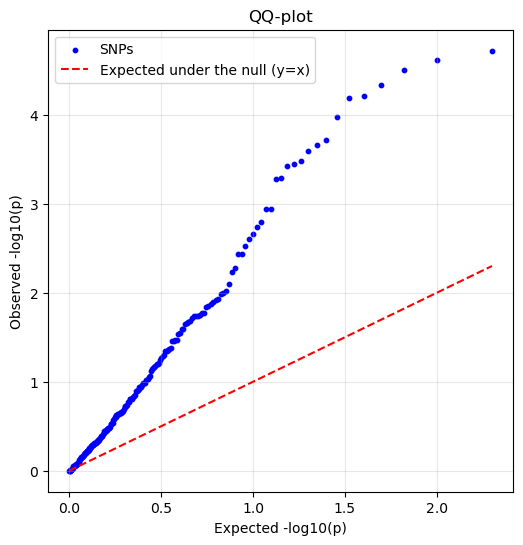

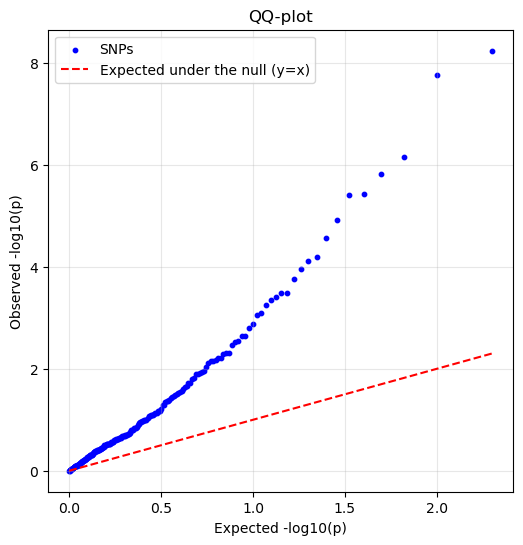

In [63]:
qqplot(results_df.query("phenotype == 'LR_number_adj_irn'").p_value)
qqplot(results_df.query("phenotype == 'LR_Density_adj_irn'").p_value)

In [44]:
all_data.min(axis=0).sort_values()

PR_Length_adj_irn          -3.760749
LR_number_adj_irn          -3.760749
LR_Density_adj_irn         -3.760749
(PRKV01000012.1, 27754)     0.042254
(PRKV01000009.1, 241180)    0.050000
                              ...   
(PRKV01000002.1, 143111)    0.500000
(PRKV01000002.1, 104934)    0.500000
(PRKV01000031.1, 36626)     0.500000
(PRKV01000005.1, 1)         0.500000
(PRKV01000013.1, 128134)    0.500000
Length: 203, dtype: float64

In [46]:
# PRKV01000004.1, 665
# pp = all_data.groupby(("contig000024", 14027)).agg("mean").reset_index()
# pp = all_data[[SNP]]# all_data.groupby(SNP).agg("mean").reset_index()
@interact
def select_association(index=widgets.IntSlider(min=0,max=100)):
    # index = 10
    SNP = results_df.SNP.iloc[index] # ("PRKV01000004.1", 66535)
    phenotype = results_df.phenotype.iloc[index]
    
    plt.scatter(all_data[[SNP]], all_data[[phenotype]]);
    plt.title(SNP)

interactive(children=(IntSlider(value=0, description='index'), Output()), _dom_classes=('widget-interact',))

___

In [47]:
gff = "/home/rodrigo/Postdoc/plant-microbiota-interaction/data/genomes/reference/ensembl_compatible.gff3"

In [48]:
gff = "/home/rodrigo/Postdoc/plant-microbiota-interaction/data/genomes/reference_2/annotations/annotations2.gff3"

In [49]:
annot = pd.read_csv(gff, sep='\t', header=None)

FileNotFoundError: [Errno 2] No such file or directory: '/home/rodrigo/Postdoc/plant-microbiota-interaction/data/genomes/reference_2/annotations/annotations2.gff3'

In [55]:
col_names = ["seqid", "source", "type", "start", "end", "score", "strand", "phase", "attributes"]
gff_data = pd.read_csv(
    gff,
    sep="\t",
    comment="#",  # Skip comment lines
    names=col_names,
    dtype={"seqid": str, "source": str, "type": str, "start": int, "end": int, "score": str, "strand": str, "phase": str, "attributes": str},
)

# Preview the data
print(gff_data.head())

# Example: Extracting genes
genes = gff_data[gff_data['type'] == 'gene']
# gff_data['contig'] = gff_data.seqid.apply(lambda x: x.split("_")[1].split(".")[0])
gff_data.attributes = gff_data.attributes.apply(lambda x: x.split(";"))

            seqid            source    type  start     end score strand phase  \
0  PRKV01000011.1           Genbank  region      1  184751     .      +     .   
1  PRKV01000011.1           Genbank    gene    265    1509     .      +     .   
2  PRKV01000011.1  Protein Homology     CDS    265    1509     .      +     0   
3  PRKV01000011.1           Genbank    gene   1502    2557     .      +     .   
4  PRKV01000011.1  Protein Homology     CDS   1502    2557     .      +     0   

                                          attributes  
0  ID=PRKV01000011.1:1..184751;Dbxref=taxon:1404;...  
1  ID=gene-C2I27_15215;Name=C2I27_15215;gbkey=Gen...  
2  ID=cds-PVC67978.1;Parent=gene-C2I27_15215;Dbxr...  
3  ID=gene-C2I27_15220;Name=C2I27_15220;gbkey=Gen...  
4  ID=cds-PVC67979.1;Parent=gene-C2I27_15220;Dbxr...  


In [56]:
gff_data.attributes = gff_data.attributes.apply(lambda xx: {x.split("=")[0]:x.split("=")[1] for x in xx})

In [57]:
results_df

,SNP,phenotype,p_value,beta,r_squared
0,"(PRKV01000002.1, 13730)",PR_Length_adj_irn,0.744604,-0.060245,0.000063
1,"(PRKV01000002.1, 13730)",LR_number_adj_irn,0.094454,0.308587,0.001654
2,"(PRKV01000002.1, 13730)",LR_Density_adj_irn,0.212750,0.230386,0.000919
3,"(PRKV01000002.1, 13915)",PR_Length_adj_irn,0.165011,0.219581,0.000966
4,"(PRKV01000002.1, 13915)",LR_number_adj_irn,0.521499,0.101233,0.000206
...,...,...,...,...,...
595,"(PRKV01000035.1, 606980)",LR_number_adj_irn,0.706354,0.042402,0.000053
596,"(PRKV01000035.1, 606980)",LR_Density_adj_irn,0.123544,-0.173569,0.000892
597,"(PRKV01000035.1, 606983)",PR_Length_adj_irn,0.087681,0.217494,0.001070
598,"(PRKV01000035.1, 606983)",LR_number_adj_irn,0.062954,-0.236463,0.001268


In [73]:
gff_gene_data = gff_data.query("type == 'CDS'")
gff_gene_data

,seqid,source,type,start,end,score,strand,phase,attributes
2,PRKV01000011.1,Protein Homology,CDS,265,1509,.,+,0,"{'ID': 'cds-PVC67978.1', 'Parent': 'gene-C2I27..."
4,PRKV01000011.1,Protein Homology,CDS,1502,2557,.,+,0,"{'ID': 'cds-PVC67979.1', 'Parent': 'gene-C2I27..."
6,PRKV01000011.1,Protein Homology,CDS,2750,4024,.,+,0,"{'ID': 'cds-PVC67980.1', 'Parent': 'gene-C2I27..."
8,PRKV01000011.1,Protein Homology,CDS,4543,5376,.,+,0,"{'ID': 'cds-PVC67981.1', 'Parent': 'gene-C2I27..."
10,PRKV01000011.1,Protein Homology,CDS,6281,7675,.,+,0,"{'ID': 'cds-PVC68147.1', 'Parent': 'gene-C2I27..."
...,...,...,...,...,...,...,...,...,...
11730,PRKV01000001.1,Protein Homology,CDS,63681,64289,.,+,0,"{'ID': 'cds-PVC76758.1', 'Parent': 'gene-C2I27..."
11732,PRKV01000001.1,Protein Homology,CDS,64317,64994,.,-,0,"{'ID': 'cds-PVC76759.1', 'Parent': 'gene-C2I27..."
11734,PRKV01000001.1,Protein Homology,CDS,65114,66700,.,-,0,"{'ID': 'cds-PVC76760.1', 'Parent': 'gene-C2I27..."
11736,PRKV01000001.1,Protein Homology,CDS,66945,67139,.,-,0,"{'ID': 'cds-PVC76761.1', 'Parent': 'gene-C2I27..."


In [74]:
annotations = list()

count= 0
for i, row in results_df.iterrows():

    variant_contig = row.SNP[0] # row.contig
    variant_position = row.SNP[1] # row.position

    matching_rows = gff_gene_data[
        # (gff_data["contig"] == variant_contig) & 
        (gff_gene_data["seqid"] == variant_contig) & 
        (gff_gene_data["start"] <= variant_position) & 
        (gff_gene_data["end"] >= variant_position)
    ]
    
    annotations.append(matching_rows.attributes if len(matching_rows) > 0 else None)

    # Result
    if matching_rows.empty:        
        # print("Variant belongs to the following rows:")
        # print(matching_rows)
        count += 1
        print("Variant does not belong to any row.")
        
print(count)

Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to any row.
Variant does not belong to a

In [75]:
results_df['contig'] = results_df.SNP.apply(lambda x: x[0])
results_df['position'] = results_df.SNP.apply(lambda x: x[1])

In [76]:
results_df["annotation"] = pd.Series(annotations).apply(lambda x: None if x is None else x.to_list()[0])

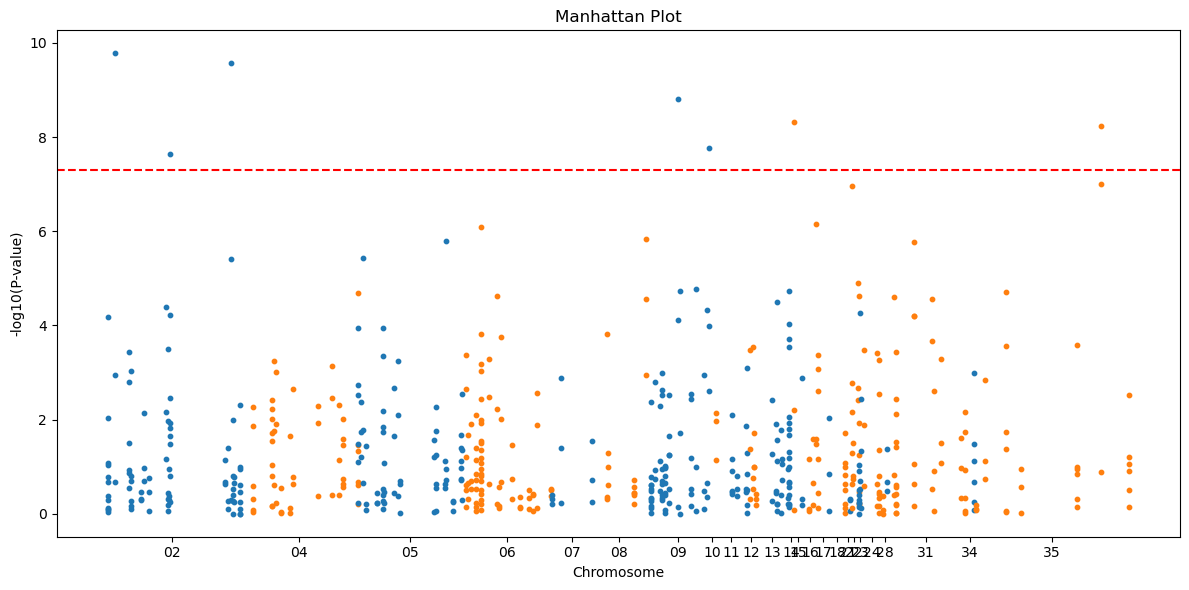

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sort chromosomes naturally (1, 2, ..., X)
results_df['Chromosome'] = pd.Categorical(results_df['contig'], 
                                    categories=sorted(results_df['contig'].unique(), key=lambda x: (not x.isdigit(), x)),
                                    ordered=True)
results_df = results_df.sort_values(['Chromosome', 'position'])

# Add a column for -log10(P-value)
results_df['-log10(P-value)'] = -np.log10(results_df['p_value'])

# Generate chromosome-specific positions
chrom_offsets = {}
cumulative_position = 0

for chrom in results_df['Chromosome'].cat.categories:
    chrom_data = results_df[results_df['Chromosome'] == chrom]
    chrom_offsets[chrom] = cumulative_position
    results_df.loc[results_df['Chromosome'] == chrom, 'Cumulative Position'] = chrom_data['position'] + cumulative_position
    cumulative_position += chrom_data['position'].max()

# Create the plot
plt.figure(figsize=(12, 6))

# Alternate colors for chromosomes
colors = ['#1f77b4', '#ff7f0e']
for i, chrom in enumerate(results_df['Chromosome'].cat.categories):
    chrom_data = results_df[results_df['Chromosome'] == chrom]
    plt.scatter(chrom_data['Cumulative Position'], chrom_data['-log10(P-value)'], 
                c=colors[i % len(colors)], s=10, label=f"Chr {chrom}")

# Add a genome-wide significance line (optional)
significance_threshold = -np.log10(5e-8)
plt.axhline(y=significance_threshold, color='red', linestyle='--', label='Genome-wide significance')

labels = [x[10:-2] for x in chrom_offsets.keys()]

# Customize the plot
plt.xlabel('Chromosome')
plt.ylabel('-log10(P-value)')
plt.title('Manhattan Plot')
plt.xticks(ticks=[chrom_offsets[chrom] + (results_df[results_df['Chromosome'] == chrom]['position'].max() / 2) for chrom in chrom_offsets],
           labels=labels, rotation=0)
# plt.legend(loc='upper right')
plt.tight_layout()

# Show the plot
plt.show()

In [78]:
results_df.phenotype.unique()

array(['PR_Length_adj_irn', 'LR_number_adj_irn', 'LR_Density_adj_irn'],
      dtype=object)

In [79]:
results_per_pheno_df = results_df.query("phenotype == 'LR_Density_adj_irn'")

In [80]:
results_per_pheno_df = results_per_pheno_df.apply(lambda x: str(x))

In [91]:
results_df['annotation_as_str'] = results_df.annotation.apply(lambda x: "None" if x is None else str(x.get("product", "None")))

In [92]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Assuming results_df is already defined and contains columns: contig, position, p_value, annotation
# Sort chromosomes naturally (1, 2, ..., X)
results_df['Chromosome'] = pd.Categorical(
    results_df['contig'], 
    categories=sorted(results_df['contig'].unique(), key=lambda x: (not x.isdigit(), x)),
    ordered=True
)
results_df = results_df.sort_values(['Chromosome', 'position'])

# Add a column for -log10(P-value)
results_df['-log10(P-value)'] = -np.log10(results_df['p_value'])

# Generate chromosome-specific positions
chrom_offsets = {}
cumulative_position = 0
ticks = []

for chrom in results_df['Chromosome'].cat.categories:
    chrom_data = results_df[results_df['Chromosome'] == chrom]
    chrom_offsets[chrom] = cumulative_position
    results_df.loc[results_df['Chromosome'] == chrom, 'Cumulative Position'] = (
        chrom_data['position'] + cumulative_position
    )
    ticks.append(cumulative_position + (chrom_data['position'].max() / 2))
    cumulative_position += chrom_data['position'].max()

# Create interactive scatter plot
fig = px.scatter(
    results_df,
    x='Cumulative Position',
    y='-log10(P-value)',
    color='Chromosome',
    hover_data={
        'Chromosome': True,
        'position': True,
        'p_value': True,
        'annotation_as_str': True,  # Include annotation in hover data
        'Cumulative Position': False  # Hide cumulative position from hover
    },
    title='Interactive Manhattan Plot',
    labels={'Cumulative Position': 'Chromosome', '-log10(P-value)': '-log10(P-value)'},
    color_discrete_sequence=px.colors.qualitative.Set3
)

# Add genome-wide significance threshold
significance_threshold = -np.log10(5e-2/600)
fig.add_hline(
    y=significance_threshold,
    line_dash="dash",
    line_color="red",
    annotation_text="Genome-wide significance",
    annotation_position="top left"
)


labels = [x[10:-2] for x in  results_df['Chromosome'].cat.categories]

# Customize axis
fig.update_layout(
    xaxis=dict(
        title='Contig',
        tickvals=ticks,
        ticktext=labels
    ),
    yaxis=dict(title='-log10(P-value)'),
    legend_title='Contig',
    template='plotly_white'
)

# Show the plot
fig.show()


In [83]:
from Bio import SeqIO

def get_contig_range(input_fasta, contig_name, start=None, end=None):
    """
    Retrieves a specific contig (and optionally a range within it) as a string.

    Parameters:
    - input_fasta: str, path to the input FASTA file.
    - contig_name: str, the name of the contig to query.
    - start: int or None, start position (1-based, inclusive). Default is None for full contig.
    - end: int or None, end position (1-based, inclusive). Default is None for full contig.

    Returns:
    - str: The extracted sequence as a string.
    - None: If the contig is not found.
    """
    for record in SeqIO.parse(input_fasta, "fasta"):
        if record.id == contig_name:
            if start is not None and end is not None:
                return str(record.seq[start - 1:end])
            return str(record.seq)
    print(f"Contig '{contig_name}' not found in {input_fasta}")
    return None

In [84]:
results_df

,SNP,phenotype,p_value,beta,r_squared,contig,position,annotation,Chromosome,-log10(P-value),Cumulative Position,annotation_as_str
0,"(PRKV01000002.1, 13730)",PR_Length_adj_irn,0.744604,-0.060245,0.000063,PRKV01000002.1,13730,None,PRKV01000002.1,0.128075,13730.0,None
1,"(PRKV01000002.1, 13730)",LR_number_adj_irn,0.094454,0.308587,0.001654,PRKV01000002.1,13730,None,PRKV01000002.1,1.024780,13730.0,None
2,"(PRKV01000002.1, 13730)",LR_Density_adj_irn,0.212750,0.230386,0.000919,PRKV01000002.1,13730,None,PRKV01000002.1,0.672131,13730.0,None
3,"(PRKV01000002.1, 13915)",PR_Length_adj_irn,0.165011,0.219581,0.000966,PRKV01000002.1,13915,None,PRKV01000002.1,0.782488,13915.0,None
4,"(PRKV01000002.1, 13915)",LR_number_adj_irn,0.521499,0.101233,0.000206,PRKV01000002.1,13915,None,PRKV01000002.1,0.282747,13915.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
595,"(PRKV01000035.1, 606980)",LR_number_adj_irn,0.706354,0.042402,0.000053,PRKV01000035.1,606980,"{'ID': 'cds-PVC61973.1', 'Parent': 'gene-C2I27...",PRKV01000035.1,0.150978,4020057.0,"{'ID': 'cds-PVC61973.1', 'Parent': 'gene-C2I27..."
596,"(PRKV01000035.1, 606980)",LR_Density_adj_irn,0.123544,-0.173569,0.000892,PRKV01000035.1,606980,"{'ID': 'cds-PVC61973.1', 'Parent': 'gene-C2I27...",PRKV01000035.1,0.908178,4020057.0,"{'ID': 'cds-PVC61973.1', 'Parent': 'gene-C2I27..."
597,"(PRKV01000035.1, 606983)",PR_Length_adj_irn,0.087681,0.217494,0.001070,PRKV01000035.1,606983,"{'ID': 'cds-PVC61973.1', 'Parent': 'gene-C2I27...",PRKV01000035.1,1.057096,4020060.0,"{'ID': 'cds-PVC61973.1', 'Parent': 'gene-C2I27..."
598,"(PRKV01000035.1, 606983)",LR_number_adj_irn,0.062954,-0.236463,0.001268,PRKV01000035.1,606983,"{'ID': 'cds-PVC61973.1', 'Parent': 'gene-C2I27...",PRKV01000035.1,1.200980,4020060.0,"{'ID': 'cds-PVC61973.1', 'Parent': 'gene-C2I27..."


In [85]:
results_df.sort_values("p_value")# .annotation.iloc[0]

,SNP,phenotype,p_value,beta,r_squared,contig,position,annotation,Chromosome,-log10(P-value),Cumulative Position,annotation_as_str
12,"(PRKV01000002.1, 42521)",PR_Length_adj_irn,1.664385e-10,0.853178,2.193758e-02,PRKV01000002.1,42521,None,PRKV01000002.1,9.778746,42521.0,None
63,"(PRKV01000002.1, 496961)",PR_Length_adj_irn,2.642433e-10,0.876563,1.849527e-02,PRKV01000002.1,496961,"{'ID': 'cds-PVC76004.1', 'Parent': 'gene-C2I27...",PRKV01000002.1,9.577996,496961.0,"{'ID': 'cds-PVC76004.1', 'Parent': 'gene-C2I27..."
339,"(PRKV01000009.1, 124951)",PR_Length_adj_irn,1.564588e-09,0.995325,2.085614e-02,PRKV01000009.1,124951,None,PRKV01000009.1,8.805600,2249627.0,None
435,"(PRKV01000014.1, 19526)",PR_Length_adj_irn,4.851976e-09,1.115879,2.412343e-02,PRKV01000014.1,19526,None,PRKV01000014.1,8.314081,2703798.0,None
593,"(PRKV01000035.1, 495534)",LR_Density_adj_irn,5.709684e-09,-0.784642,2.321614e-02,PRKV01000035.1,495534,None,PRKV01000035.1,8.243388,3908611.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...
490,"(PRKV01000023.1, 2787)",LR_number_adj_irn,9.948478e-01,-0.000758,1.295156e-08,PRKV01000023.1,2787,None,PRKV01000023.1,0.002243,2962229.0,None
521,"(PRKV01000024.1, 89343)",LR_Density_adj_irn,9.959133e-01,0.000655,1.761316e-08,PRKV01000024.1,89343,None,PRKV01000024.1,0.001778,3056569.0,None
78,"(PRKV01000002.1, 531984)",PR_Length_adj_irn,9.965046e-01,0.000753,1.253144e-08,PRKV01000002.1,531984,"{'ID': 'cds-PVC76033.1', 'Parent': 'gene-C2I27...",PRKV01000002.1,0.001521,531984.0,"{'ID': 'cds-PVC76033.1', 'Parent': 'gene-C2I27..."
343,"(PRKV01000009.1, 132078)",LR_number_adj_irn,9.973579e-01,-0.000435,4.057470e-09,PRKV01000009.1,132078,None,PRKV01000009.1,0.001149,2256754.0,None


In [86]:
# Example usage
input_file = "data/genomes/reference_2/full_sequence.fasta"
contig = "PRKV01000004.1"
start_position = 394240 - 200
end_position = 394240 + 200

get_contig_range(input_file, contig, start_position, end_position)

'ATAAAAAAGCCAAAAAAACCTAAAATGCTGACACAGATAATACTAAAAAAGCGGATCAGTGAAATTGTTCCTATAAGGGACTGATTCGCTAGCGTAAAGGTAGCAATCGTAGAGCCTGCAATGACAACAAGCATGGCAGGACTTGTTAAACCGGCTCTAATGGCTGCATCACCGATAATAAGACCTCCGATTACACTGAGTGTCTGCCCGACAGAAGTCGGGAGTCTAAACCCTGCCTCTCGAAACAATTCAAATAAAAGAAGCATTAGTATCGCTTCAAGAGAGGTAGGAAACGGGACACCTCTTCTTGCCTCAACAATCGTAGCTAATAAGCTGAGCGGAAGCTGATTTTGATGAAAAGCCGTCATTGCAACCCAAAAACCAGGCAAAAAAGCAGCGAT'